# Tools

In [1]:
import os, sys

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
%matplotlib notebook

In [4]:
import waveprop, imp
imp.reload(waveprop)

<module 'waveprop' from '/home/97n/dv/sts/cupi2d/waveprop.py'>

# Constants

## Absorption

In [9]:
v0 = 2200 # m/s
lambda0 = 3.956/(v0/1e3)
lambda0 # wavelength corresponding to 2200m/s

1.798181818181818

In [11]:
sigma0_Gd = 49700 # barn
density_Gd = 7.90 # g/cm3

In [13]:
amu = 1.66e-27 # kg

In [17]:
density_Gd*1e-3/1e-6/amu

4.759036144578314e+30

In [20]:
mu0_Gd = sigma0_Gd*1e-28*density_Gd*1e-3/1e-6/(157.25*amu)

In [25]:
np.exp(-mu0_Gd*1e-5)

0.2222110220205065

## Phase

pi grating at 37um 4.1AA

In [106]:
phase_over_Dlambda = np.pi/37e-6/4.1e-10

In [107]:
phase_over_Dlambda * 45e-6 * 3.35e-10

3.12191886966817

# Main function

In [108]:
def nGI(
    wavelength = 3.35e-10, d01= 6.4, d12 = 2.379e-2,
    g1_thickness = 45e-6,
    grPeriod = 7.97e-6, np_gr = 64, # number of points within the grating period
    npoints = 2**12,
    verbose = False,
):
    Lx = npoints*grPeriod/np_gr
    zt = (grPeriod/2)**2/wavelength
    X = np.linspace(-Lx/2, Lx/2, npoints)
    if verbose:
        print('Lx = {:.3f} um'.format(Lx*1e6))
        print('npoints period = {:d}'.format(np_gr))
        print('npoints total = {:d}'.format(npoints))
        print('grating lateral size = {:.2f} um'.format(grPeriod*np_gr*1e6))
    # source
    sigma_x = 1e-3
    emSource = ((1j)*X*0.0 +1.0)*np.exp(-X**2/sigma_x**2)
    sourceStr = 'planeWave'
    # grid
    Nrows = npoints//np_gr
    gr0 = np.zeros((Nrows, np_gr))
    gr0[:, :np_gr//2] = 1
    gr0.shape = -1,
    marginx = (npoints - gr0.shape[0])//2
    gr0 = np.pad(gr0, ((marginx, marginx),), mode='constant', constant_values=(1,))
    gr0 = np.pad(gr0, ((0, npoints - gr0.shape[0]),), mode='constant', constant_values=(1,))
    gr0.shape
    # phase grid
    gr = np.exp(-1j*gr0*wavelength*g1_thickness*phase_over_Dlambda) # Pi phase grating
    #gr = np.exp(-1j*np.pi/2*gr0) # Pi/2 phase grating
    # propagate to before phase grating
    if verbose:
        waveprop.fresnelNumber(grPeriod, 6., wavelength, verbose=True)
    em_b4_gr = waveprop.propTF_RayleighSommerfeld_1D(emSource, Lx, wavelength, d01)
    # after phase grating
    after_grating = em_b4_gr * gr
    # propagate to detector
    if verbose:
        waveprop.fresnelNumber(grPeriod, d12, wavelength, verbose=True)
    u2_x = waveprop.propTF_RayleighSommerfeld_1D(after_grating,Lx, wavelength, d12)
    return gr0, gr, em_b4_gr, after_grating, u2_x

In [109]:
def calc_visibitilty(
    wl, g0_slit_width, g0_period, g0_thickness = 10e-6, # assume Gd
    g1_thickness = 45e-6,
    g2_thickness = 6e-6,
    d01= 6.4, d12 = 2.379e-2, grPeriod = 7.97e-6, np_gr = 64, 
    verbose=False,
    **kwds):
    gr0, gr, em_b4_gr, after_grating, u2_x = nGI(
        wavelength = wl, grPeriod=grPeriod, g1_thickness=g1_thickness,
        np_gr=np_gr, d01=d01, d12=d12,
        **kwds)
    # sl = slice(npoints//2-np_gr*10, npoints//2+np_gr*10)
    sl = slice(None, None)
    y = u2_x[sl]
    N = y.size
    dx = grPeriod/np_gr
    x = np.arange(-(N-1.)/2*dx, (N-1.)/2*dx+0.1*dx, dx)
    # G0 projectec
    Tr = np.exp(-mu0_Gd*wl/lambda0*1e10*g0_thickness) # transmission 
    if verbose:
        print("transmission:", Tr)
    projected_g0_slit_width = g0_slit_width*d12/d01
    projected_g0_period = g0_period*d12/d01
    N1 = int((x[-1]-x[0])//projected_g0_period)
    y_G0_proj = np.ones(x.size)*Tr
    for i in range(N1+1):
        xstart = x[0] + projected_g0_period*i
        xstart = min(xstart, x[-1])
        xend = xstart + projected_g0_slit_width
        mask = (x>=xstart)*(x<xend)
        y_G0_proj[mask] = 1.
    y_G0_proj/=np.sum(y_G0_proj)
    y2 = np.convolve(np.abs(y)**2, y_G0_proj, mode='same')
    # G2
    Tr = np.exp(-mu0_Gd*wl/lambda0*1e10*g2_thickness) # transmission 
    y_G2 = np.ones(y.shape)*Tr
    y_G2.shape = -1, np_gr//2
    y_G2[:, :np_gr//4] = 1
    y_G2.shape = -1,
    y_G2/=np.sum(y_G2)
    y3 = np.convolve(y2, y_G2, mode='same')
    y3_middle = y3[N//2-np_gr: N//2+np_gr]
    ymax, ymin = np.max(y3_middle), np.min(y3_middle)
    V = (ymax-ymin)/(ymax+ymin)
    return x, y, y_G0_proj, y_G2, y2, y3, V

# One wavelength

In [110]:
np_gr = 64 # number of points within the grating period
npoints = 2**12

In [111]:
gr0, gr, em_b4_gr, after_grating, u2_x = nGI(wavelength = 3.35e-10, npoints=npoints, np_gr=np_gr)

<IPython.core.display.Javascript object>


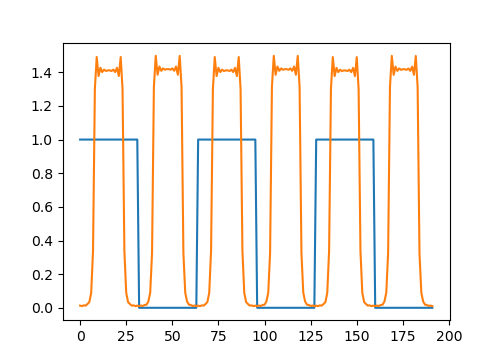

In [112]:
plt.figure(figsize=(5,3.6))
sl = slice(npoints//2, npoints//2+np_gr*3)
plt.plot(gr0[sl])
plt.plot(np.abs(u2_x)[sl])

In [113]:
x, y, projected_G0, y_G2, y2, y3, V = calc_visibitilty(
    3.35e-10, g0_slit_width=400e-6, g0_period=1075e-6, npoints=npoints, np_gr=np_gr)
print(V)

0.3168427490797172


<IPython.core.display.Javascript object>


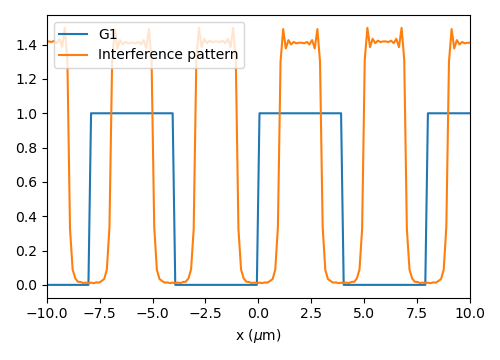

In [114]:
plt.figure(figsize=(5,3.6))
xp = x*1e6
plt.plot(xp, gr0, label='G1')
plt.plot(xp, np.abs(u2_x), label='Interference pattern')
plt.legend(loc='upper left')
plt.xlim(-10, 10)
plt.xlabel('x ($\mu$m)')
plt.tight_layout()

<IPython.core.display.Javascript object>


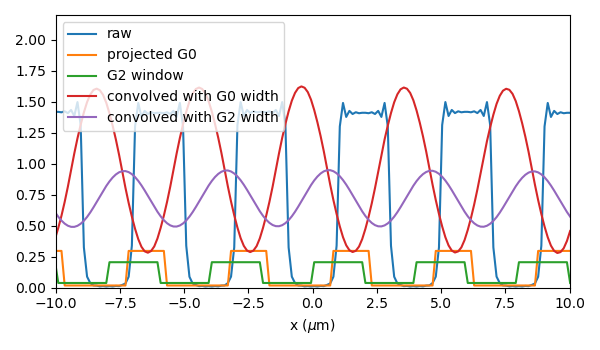

In [115]:
plt.figure(figsize=(6,3.5))
xp = x*1e6
plt.plot(xp, np.abs(y), label='raw')
plt.plot(xp, projected_G0*500, label='projected G0')
# plt.plot(xp, gr0[sl], label='G1')
plt.plot(xp, y_G2*500, label='G2 window')
plt.plot(xp, y2, label='convolved with G0 width')
plt.plot(xp, y3, label='convolved with G2 width')
plt.xlim(-10, 10)
plt.ylim(0, 2.2)
plt.xlabel('x ($\mu$m)')
plt.legend(loc='upper left')
plt.tight_layout()

In [116]:
V

0.3168427490797172

# Scan wavelength

In [129]:
%%time
Vs = []
wls = np.arange(.5, 12, .1)
for wl in wls:
    x, y, gaussian, rect, y2, y3, V = calc_visibitilty(
        wl*1e-10, g0_slit_width=400e-6, g0_period=1075e-6, npoints=npoints, np_gr=np_gr)
    Vs.append(V)

CPU times: user 553 ms, sys: 0 ns, total: 553 ms
Wall time: 553 ms


<IPython.core.display.Javascript object>


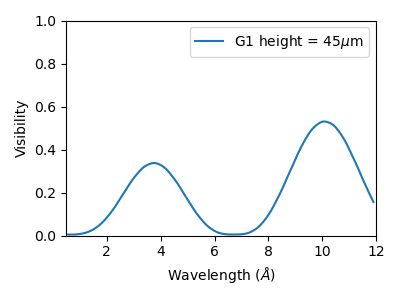

In [136]:
plt.figure(figsize=(4,3))
plt.plot(wls, Vs, label = 'G1 height = 45$\mu$m')
plt.ylim(0,1)
plt.xlim(0.5, 12)
plt.ylabel('Visibility')
plt.xlabel(r'Wavelength ($\AA$)')
plt.legend()
plt.tight_layout()

# Scan wavelength and G1 thickness

In [132]:
import tqdm

In [133]:
%%time
Vmat = []
wls = np.arange(.5, 12, .1)
g1ts = np.arange(5, 150, 2.)
for wl in tqdm.tqdm(wls):
    _vs = []
    for g1t in g1ts:
        x, y, gaussian, rect, y2, y3, V = calc_visibitilty(
            wl*1e-10, g0_slit_width=400e-6, g0_period=1075e-6, g1_thickness=g1t*1e-6, npoints=npoints, np_gr=np_gr)
        _vs.append(V)
    Vmat.append(_vs)

100%|██████████| 115/115 [00:39<00:00,  2.90it/s]

CPU times: user 39.7 s, sys: 21.2 ms, total: 39.7 s
Wall time: 39.7 s


<IPython.core.display.Javascript object>


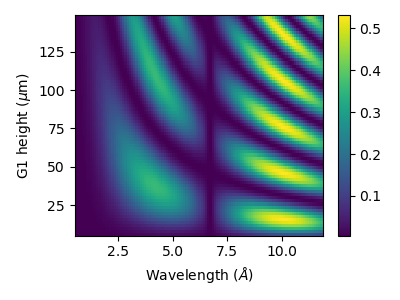

<ipython-input-135-a31a8439856c>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(wlg, g1tg, Vmat.T)


In [135]:
Vmat = np.array(Vmat)
plt.figure(figsize=(4,3))
wlg, g1tg = np.meshgrid(wls, g1ts)
plt.pcolormesh(wlg, g1tg, Vmat.T)
plt.colorbar()
plt.ylabel('G1 height ($\mu$m)')
plt.xlabel('Wavelength ($\AA$)')
plt.tight_layout()